### Install necessary packages, might also need torch, numpy and sklearn. In Kaggle these are already pre-installed.


In [1]:
!pip install -q "mamba-ssm[causal-conv1d]" # Install mamba-ssm with causal-conv1d extras 
!pip3 install -q -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
# Kaggle has these preinstalled, but to be sure we install them again.
!pip install -q monai einops nibabel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.9/841.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


### Imports

In [2]:
# from https://github.com/ge-xing/SegMamba
# mamba_ssm (install only if missing)
import importlib, sys, subprocess
if importlib.util.find_spec("mamba_ssm") is None:
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "mamba-ssm"], check=True)

from mamba_ssm import Mamba
print("Mamba loaded successfully")

import os, random, warnings, shutil, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from monai.data import PersistentDataset, DataLoader, decollate_batch, list_data_collate, Dataset
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Orientationd,
    Spacingd, CropForegroundd, SpatialPadd, DivisiblePadd,
    ScaleIntensityRangePercentilesd, AsDiscreted,
    RandCropByPosNegLabeld, RandFlipd, RandAffined, RandRotated,
    RandGaussianNoised, RandGaussianSmoothd,
    DeleteItemsd, AsDiscrete, KeepLargestConnectedComponent,
)
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss


# MODEL DEFINITIONS (FROM GITHUB OF SegMamba)
from functools import partial
from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.blocks.unetr_block import UnetrBasicBlock, UnetrUpBlock

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None, None] * x + self.bias[:, None, None, None]
            return x

class MambaLayer(nn.Module):
    def __init__(self, dim, d_state=16, d_conv=4, expand=2, num_slices=None):
        super().__init__()
        self.dim = dim
        self.norm = nn.LayerNorm(dim)
        self.mamba = Mamba(
            d_model=dim,
            d_state=d_state,
            d_conv=d_conv,
            expand=expand,
        )

    def forward(self, x):
        B, C = x.shape[:2]
        x_skip = x
        assert C == self.dim
        n_tokens = x.shape[2:].numel()
        img_dims = x.shape[2:]
        x_flat = x.reshape(B, C, n_tokens).transpose(-1, -2)
        x_norm = self.norm(x_flat)
        x_mamba = self.mamba(x_norm)
        out = x_mamba.transpose(-1, -2).reshape(B, C, *img_dims)
        out = out + x_skip
        return out

class MlpChannel(nn.Module):
    def __init__(self, hidden_size, mlp_dim):
        super().__init__()
        self.fc1 = nn.Conv3d(hidden_size, mlp_dim, 1)
        self.act = nn.GELU()
        self.fc2 = nn.Conv3d(mlp_dim, hidden_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

class GSC(nn.Module):
    def __init__(self, in_channles) -> None:
        super().__init__()
        self.proj = nn.Conv3d(in_channles, in_channles, 3, 1, 1)
        self.norm = nn.InstanceNorm3d(in_channles)
        self.nonliner = nn.ReLU()

        self.proj2 = nn.Conv3d(in_channles, in_channles, 3, 1, 1)
        self.norm2 = nn.InstanceNorm3d(in_channles)
        self.nonliner2 = nn.ReLU()

        self.proj3 = nn.Conv3d(in_channles, in_channles, 1, 1, 0)
        self.norm3 = nn.InstanceNorm3d(in_channles)
        self.nonliner3 = nn.ReLU()

        self.proj4 = nn.Conv3d(in_channles, in_channles, 1, 1, 0)
        self.norm4 = nn.InstanceNorm3d(in_channles)
        self.nonliner4 = nn.ReLU()

    def forward(self, x):
        x_residual = x

        x1 = self.proj(x)
        x1 = self.norm(x1)
        x1 = self.nonliner(x1)

        x1 = self.proj2(x1)
        x1 = self.norm2(x1)
        x1 = self.nonliner2(x1)

        x2 = self.proj3(x)
        x2 = self.norm3(x2)
        x2 = self.nonliner3(x2)

        x = x1 + x2
        x = self.proj4(x)
        x = self.norm4(x)
        x = self.nonliner4(x)

        return x + x_residual

class MambaEncoder(nn.Module):
    def __init__(self, in_chans=1, depths=[2, 2, 2, 2], dims=[48, 96, 192, 384],
                 drop_path_rate=0., layer_scale_init_value=1e-6, out_indices=[0, 1, 2, 3]):
        super().__init__()

        self.downsample_layers = nn.ModuleList()
        stem = nn.Sequential(
            nn.Conv3d(in_chans, dims[0], kernel_size=7, stride=2, padding=3),
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                nn.InstanceNorm3d(dims[i]),
                nn.Conv3d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()
        self.gscs = nn.ModuleList()
        num_slices_list = [64, 32, 16, 8]
        for i in range(4):
            gsc = GSC(dims[i])
            stage = nn.Sequential(
                *[MambaLayer(dim=dims[i], num_slices=num_slices_list[i]) for _ in range(depths[i])]
            )
            self.stages.append(stage)
            self.gscs.append(gsc)

        self.out_indices = out_indices

        self.mlps = nn.ModuleList()
        for i_layer in range(4):
            layer = nn.InstanceNorm3d(dims[i_layer])
            layer_name = f"norm{i_layer}"
            self.add_module(layer_name, layer)
            self.mlps.append(MlpChannel(dims[i_layer], 2 * dims[i_layer]))

    def forward_features(self, x):
        outs = []
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.gscs[i](x)
            x = self.stages[i](x)

            if i in self.out_indices:
                norm_layer = getattr(self, f"norm{i}")
                x_out = norm_layer(x)
                x_out = self.mlps[i](x_out)
                outs.append(x_out)
        return tuple(outs)

    def forward(self, x):
        return self.forward_features(x)

class SegMamba(nn.Module):
    def __init__(
        self,
        in_chans=1,
        out_chans=1,
        depths=[2, 2, 2, 2],
        feat_size=[48, 96, 192, 384],
        drop_path_rate=0,
        layer_scale_init_value=1e-6,
        hidden_size: int = 768,
        norm_name="instance",
        conv_block: bool = True,
        res_block: bool = True,
        spatial_dims=3,
    ) -> None:
        super().__init__()

        self.hidden_size = hidden_size
        self.in_chans = in_chans
        self.out_chans = out_chans
        self.depths = depths
        self.drop_path_rate = drop_path_rate
        self.feat_size = feat_size
        self.layer_scale_init_value = layer_scale_init_value
        self.spatial_dims = spatial_dims

        self.vit = MambaEncoder(
            in_chans,
            depths=depths,
            dims=feat_size,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=layer_scale_init_value,
        )

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.in_chans,
            out_channels=self.feat_size[0],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[0],
            out_channels=self.feat_size[1],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[1],
            out_channels=self.feat_size[2],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[2],
            out_channels=self.feat_size[3],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )

        self.encoder5 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[3],
            out_channels=self.hidden_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )

        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.hidden_size,
            out_channels=self.feat_size[3],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[3],
            out_channels=self.feat_size[2],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[2],
            out_channels=self.feat_size[1],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[1],
            out_channels=self.feat_size[0],
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[0],
            out_channels=self.feat_size[0],
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.out = UnetOutBlock(
            spatial_dims=spatial_dims,
            in_channels=self.feat_size[0],
            out_channels=self.out_chans,
        )

    def proj_feat(self, x):
        new_view = [x.size(0)] + self.proj_view_shape
        x = x.view(new_view)
        x = x.permute(self.proj_axes).contiguous()
        return x

    def forward(self, x_in):
        outs = self.vit(x_in)
        enc1 = self.encoder1(x_in)

        x2 = outs[0]
        enc2 = self.encoder2(x2)

        x3 = outs[1]
        enc3 = self.encoder3(x3)

        x4 = outs[2]
        enc4 = self.encoder4(x4)

        enc_hidden = self.encoder5(outs[3])

        dec3 = self.decoder5(enc_hidden, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)
        out = self.decoder1(dec0)
        return self.out(out)

Mamba loaded successfully


<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2026-01-29 15:27:21.317684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769700441.502959      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769700441.556059      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769700442.014683      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769700442.014708      24 computation_placer.cc:1

### Setting up


##### Cuda environment settings and CUDA GPU check, also save the number of GPUs in NGPU variable.

In [3]:
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True,max_split_size_mb:128")
warnings.filterwarnings("ignore", message="single channel prediction")
warnings.filterwarnings("ignore", category=FutureWarning)

torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NGPU = torch.cuda.device_count() if torch.cuda.is_available() else 0
print(f"CUDA: {torch.cuda.get_device_name(0) if NGPU else 'CPU'} | GPUs={NGPU}")

CUDA: Tesla T4 | GPUs=2


##### Most hyperparameters, general configuration settings, and data paths are defined in the cell below.


In [4]:
# CONFIG
CONFIG = {
    "images_dir": "/kaggle/input/imagess/volumes/",
    "labels_dir": "/kaggle/input/labels/masks/",
    "cache_dir": "/kaggle/working/cache_",
    "best_model_path": "/kaggle/working/best_segmamba.pth",
    "clear_cache": True,

    "seed": 121,
    "epochs": 120,
    "batch_size": 1,
    "accum_steps": 4,
    "val_every": 1,

    "base_lr": 2.5e-5,
    "max_lr": 4e-4,
    "weight_decay": 2e-5,
    "warmup_epochs": 20,

    "drop_rate": 0.0,

    "spacing": (2.0, 2.0, 2.0),
    "roi_size": (96, 96, 64),
    "crop_margin": 8,
    "divisible_pad": (32, 32, 16),

    "swi_batch_size": 1,
    "overlap": 0.5,
    "init_threshold": 0.5,
    "thr_sweep_every": 5,
    "thr_grid": np.linspace(0.35, 0.65, 5).tolist(),

    "dice_weight": 1.0,
    "ce_weight": 1.0,

    "patience": 30,
    "min_delta": 0.0,

    "curriculum_stages": [
        {"epoch_start": 0, "pos": 1, "neg": 0, "desc": "Foreground-only"},
        {"epoch_start": 40, "pos": 3, "neg": 1, "desc": "Mixed sampling"},
        {"epoch_start": 70, "pos": 1, "neg": 1, "desc": "Balanced"},
    ],

    "ema_decay": 0.975,
}

##### Below is the pre-processing stack where we apply spatial normalization, intensity scaling, and data augmentation to prepare 3D medical images for model training.

In [5]:
os.makedirs(CONFIG["cache_dir"], exist_ok=True)
if CONFIG["clear_cache"]:
    shutil.rmtree(os.path.join(CONFIG["cache_dir"], "train"), ignore_errors=True)
    shutil.rmtree(os.path.join(CONFIG["cache_dir"], "val"), ignore_errors=True)

random.seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["seed"])


# TRANSFORMS (Config-Driven)
def get_transforms():
    base_transform = Compose([
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=True),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=CONFIG["spacing"], mode=("bilinear", "nearest")),
        ScaleIntensityRangePercentilesd(
            keys=["image"], lower=2.0, upper=99.9, b_min=0.0, b_max=1.0, clip=True
        ),
        AsDiscreted(keys=["label"], threshold=0.5),
        CropForegroundd(keys=["image", "label"], source_key="label", margin=CONFIG["crop_margin"]),
        SpatialPadd(keys=["image", "label"], spatial_size=CONFIG["roi_size"], method="symmetric"),
        DivisiblePadd(keys=["image", "label"], k=CONFIG["divisible_pad"]),
        EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=False),
        DeleteItemsd(keys=["image_meta_dict", "label_meta_dict"]),
    ])

    def rand_transform(pos_num, neg_num):
        return Compose([
            RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=CONFIG["roi_size"],
                pos=pos_num,
                neg=neg_num,
                num_samples=4,
                allow_smaller=True,
            ),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[0]),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[1]),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[2]),
            RandRotated(
                keys=["image", "label"],
                prob=0.5,
                range_x=0.15,
                range_y=0.15,
                range_z=0.15,
                mode=("bilinear", "nearest"),
                padding_mode="zeros",
            ),
            RandAffined(
                keys=["image", "label"],
                prob=0.35,
                rotate_range=(0.0, 0.0, np.pi / 6),
                scale_range=(0.2, 0.2, 0.2),
                mode=("bilinear", "nearest"),
            ),
            RandGaussianNoised(keys=["image"], prob=0.2, mean=0.0, std=0.02),
            RandGaussianSmoothd(
                keys=["image"], prob=0.2,
                sigma_x=(0.5, 1.0), sigma_y=(0.5, 1.0), sigma_z=(0.5, 1.0)
            ),
            EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=False),
        ])

    return base_transform, rand_transform

base_transform, rand_transform = get_transforms()

##### Then we prepare the dataset and dataloaders, implementing custom dataset loading with train/validation splitting and applying cached base transforms before random augmentations during training.


In [6]:
class PlacentaDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, limit=None):
        self.images_dir = Path(images_dir)
        self.labels_dir = Path(labels_dir)
        self.transform = transform

        image_files = sorted([f for f in self.images_dir.glob("*.nii*")])
        label_files = sorted([f for f in self.labels_dir.glob("*.nii*")])

        label_map = {f.stem.replace("_mask", ""): f for f in label_files}

        self.pairs = []
        missing = []
        for img_path in image_files:
            stem = img_path.stem
            lbl_path = label_map.get(stem)
            if lbl_path is None or not lbl_path.exists():
                missing.append(img_path.name)
                continue
            self.pairs.append({"image": str(img_path), "label": str(lbl_path)})

        if limit is not None:
            self.pairs = self.pairs[:limit]

        if missing:
            print(f"[Dataset] WARNING: {len(missing)} images missing labels (showing first 3): {missing[:3]}")
        print(f"[Dataset] Loaded {len(self.pairs)} valid image-label pairs")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        sample = dict(self.pairs[idx])
        return self.transform(sample) if self.transform else sample

full_dataset = PlacentaDataset(CONFIG["images_dir"], CONFIG["labels_dir"], transform=None)

all_indices = np.arange(len(full_dataset))
train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=CONFIG["seed"])
train_items = [full_dataset.pairs[i] for i in train_idx]
val_items = [full_dataset.pairs[i] for i in val_idx]
print(f"[Split] Train: {len(train_items)} | Val: {len(val_items)}")

train_cache = PersistentDataset(train_items, transform=base_transform, cache_dir=os.path.join(CONFIG["cache_dir"], "train"))
val_cache   = PersistentDataset(val_items,   transform=base_transform, cache_dir=os.path.join(CONFIG["cache_dir"], "val"))

train_dataset = Dataset(train_cache, transform=rand_transform(1, 0))
val_dataset   = Dataset(val_cache,   transform=EnsureTyped(keys=["image", "label"], dtype=torch.float32, track_meta=False))

train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2,
    pin_memory=True,
    collate_fn=list_data_collate,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    persistent_workers=True,
    pin_memory=True,
    collate_fn=list_data_collate,
)

[Dataset] Loaded 137 valid image-label pairs
[Split] Train: 109 | Val: 28


##### And define the model, loss functions, optimizer and scheduler and pass them the parameters defined from the CONFIG map above.


In [7]:
model_core = SegMamba(
    in_chans=1,
    out_chans=1,
    feat_size=[32, 64, 128, 256, 512],
    depths=[2, 2, 2, 2, 2],
    hidden_size=1536,
    drop_path_rate=CONFIG["drop_rate"],
).to(device)

try:
    model_core = model_core.to(memory_format=torch.channels_last_3d)
except Exception:
    pass

model = model_core
print("Model: SegMamba (single GPU/CPU)")


# LOSS / OPT / SCHED / EMA

criterion = DiceCELoss(
    include_background=False,
    to_onehot_y=False,
    sigmoid=True,
    squared_pred=True,
    lambda_dice=CONFIG["dice_weight"],
    lambda_ce=CONFIG["ce_weight"],
)

dice_only_loss = DiceCELoss(include_background=False, to_onehot_y=False, sigmoid=True, squared_pred=True, lambda_dice=1.0, lambda_ce=0.0)
ce_only_loss   = DiceCELoss(include_background=False, to_onehot_y=False, sigmoid=True, squared_pred=True, lambda_dice=0.0, lambda_ce=1.0)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG["base_lr"],
    weight_decay=CONFIG["weight_decay"],
    betas=(0.9, 0.999),
)

def compute_opt_steps_per_epoch(dloader_len, accum_steps):
    return max(1, math.ceil(dloader_len / max(1, accum_steps)))

opt_steps_per_epoch = compute_opt_steps_per_epoch(len(train_loader), CONFIG["accum_steps"])
cycle_epochs = 4

scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=CONFIG["base_lr"],
    max_lr=CONFIG["max_lr"],
    step_size_up=opt_steps_per_epoch * (cycle_epochs // 2),
    step_size_down=opt_steps_per_epoch * (cycle_epochs // 2),
    mode="triangular2",
    cycle_momentum=True,
)

Model: SegMamba (single GPU/CPU)


#### Validation with EMA and some custom helper functions.

In [8]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.decay = decay
        self.shadow = {k: p.detach().clone() for k, p in model.named_parameters() if p.requires_grad}
        self.backup = None

    @torch.no_grad()
    def update(self, model):
        for k, p in model.named_parameters():
            if not p.requires_grad:
                continue
            self.shadow[k].mul_(self.decay).add_(p.detach(), alpha=1 - self.decay)

    @torch.no_grad()
    def apply(self, model):
        self.backup = {k: p.detach().clone() for k, p in model.named_parameters() if p.requires_grad}
        for k, p in model.named_parameters():
            if not p.requires_grad:
                continue
            p.data.copy_(self.shadow[k])

    @torch.no_grad()
    def restore(self, model):
        for k, p in model.named_parameters():
            if not p.requires_grad:
                continue
            p.data.copy_(self.backup[k])


ema = EMA(model, decay=CONFIG["ema_decay"])

# scaler
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

post_label = AsDiscrete(threshold=0.5)
keep_lcc = KeepLargestConnectedComponent(connectivity=3, num_components=1)


@torch.no_grad()
def postprocess_mask(bin_pred: torch.Tensor, min_size=500):
    x = keep_lcc(bin_pred)
    # Remove very small components if any remain
    if x.sum() > 0 and min_size > 0:
        components = torch.unique(x)
        if len(components) > 2:  # More than background + one component
            # This is a simple size filter - in practice you might want connected_components
            pass
    return x


@torch.no_grad()
def dice_score(y_pred_bin: torch.Tensor, y_true_bin: torch.Tensor):
    inter = (y_pred_bin * y_true_bin).sum()
    union = y_pred_bin.sum() + y_true_bin.sum()
    return float((2.0 * inter + 1e-7) / (union + 1e-7))


# val with SWI function
@torch.no_grad()
def validate_model(model, loader, threshold=0.5, do_threshold_sweep=False, calc_components=False):
    """Validation with memory-optimized sliding window inference"""
    model.eval()
    dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)
    dice_metric.reset()

    total_loss = 0.0
    total_dice_loss = 0.0
    total_ce_loss = 0.0
    iou_sum = 0.0
    n_cases = 0

    thr_grid = CONFIG["thr_grid"] if do_threshold_sweep else []
    sweep_scores = np.zeros(len(thr_grid))

    pbar = tqdm(loader, desc="Validation", leave=False)

    for batch in pbar:
        x = batch["image"].to(device, non_blocking=True).float()
        y = batch["label"].to(device, non_blocking=True).float()

        try:
            x = x.to(memory_format=torch.channels_last_3d)
            y = y.to(memory_format=torch.channels_last_3d)
        except Exception:
            pass

        # Memory-efficient sliding window with OOM recovery
        sw_bs = CONFIG["swi_batch_size"]
        logits = None

        while sw_bs >= 1:
            try:
                with torch.cuda.amp.autocast(enabled=True):
                    logits = sliding_window_inference(
                        x,
                        roi_size=CONFIG["roi_size"],
                        sw_batch_size=sw_bs,
                        predictor=model,
                        overlap=CONFIG["overlap"],
                        mode="gaussian",
                    )
                break  # Success
            except torch.cuda.OutOfMemoryError:
                torch.cuda.empty_cache()
                sw_bs //= 2
                if sw_bs < 1:
                    print(f"[OOM] Skipping batch at size {x.shape} - cannot process")
                    continue

        if logits is None:
            continue

        # Calculate losses
        loss = criterion(logits, y)
        total_loss += float(loss)

        if calc_components:
            total_dice_loss += float(dice_only_loss(logits, y))
            total_ce_loss += float(ce_only_loss(logits, y))

        probs = torch.sigmoid(logits)
        preds_bin = (probs >= threshold).float()

        # Post-process
        preds_list = decollate_batch(preds_bin)
        trues_list = decollate_batch(y > 0.5)

        preds_pp = [postprocess_mask(p) for p in preds_list]

        # Update metrics
        dice_metric(y_pred=preds_pp, y=trues_list)

        for p, t in zip(preds_pp, trues_list):
            inter = (p * t).sum()
            union = (p + t).sum()
            iou_sum += float((inter + 1e-7) / (union - inter + 1e-7))

        # Threshold sweep
        if do_threshold_sweep:
            y_bin = (y > 0.5).float()
            for i, thr in enumerate(thr_grid):
                sweep_preds = [(probs >= thr).float() for probs in decollate_batch(probs)]
                sweep_pp = [postprocess_mask(p) for p in sweep_preds]
                sweep_scores[i] += np.mean([dice_score(p, t) for p, t in zip(sweep_pp, decollate_batch(y_bin))])

        n_cases += 1

        # Clear cache periodically
        if n_cases % 10 == 0:
            torch.cuda.empty_cache()

        pbar.set_postfix({"cases": n_cases})

    # Aggregate metrics
    avg_loss = total_loss / max(n_cases, 1)
    avg_dice_loss = total_dice_loss / max(n_cases, 1) if calc_components else float('nan')
    avg_ce_loss = total_ce_loss / max(n_cases, 1) if calc_components else float('nan')
    avg_dice = dice_metric.aggregate().item()
    avg_iou = iou_sum / max(n_cases, 1)

    # Best threshold from sweep
    best_thr, best_dice_sweep = None, None
    if do_threshold_sweep and n_cases > 0:
        sweep_scores /= n_cases
        best_idx = int(np.argmax(sweep_scores))
        best_thr = float(thr_grid[best_idx])
        best_dice_sweep = float(sweep_scores[best_idx])

    # Final cleanup
    del x, y, logits, probs
    torch.cuda.empty_cache()

    return avg_loss, avg_dice_loss, avg_ce_loss, avg_dice, avg_iou, best_thr, best_dice_sweep

### Training and Validation


##### Training and validation loop, and finally printing the graphs of the dice score, training/validation loss and threshold + learning rate throughout the 120 epochs.

Starting Training...

[Curriculum] Epoch 1: Foreground-only (pos=1, neg=0)
[Memory] Before training: 0.77 GB allocated


Epoch 1/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

/tmp/ipykernel_24/337283576.py:82: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  pbar_train.set_postfix({"loss": f"{float(loss):.4f}"})


Validation:   0%|          | 0/28 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:231: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:347.)
  win_data = inputs[unravel_slice[0]].to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:347.)
  out[idx_zm] += p


[Epoch 001] TrainLoss: 1.2357 | ValLoss: 1.3626 | ValDice@thr0.50: 0.2959 | ValIoU: 0.1746 | LR: 2.50e-05 | **NEW BEST**


Epoch 2/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 002] TrainLoss: 0.9013 | ValLoss: 1.0595 | ValDice@thr0.50: 0.4854 | ValIoU: 0.3241 | LR: 3.17e-05 | **NEW BEST**


Epoch 3/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 003] TrainLoss: 0.7294 | ValLoss: 0.8256 | ValDice@thr0.50: 0.6095 | ValIoU: 0.4449 | LR: 3.84e-05 | **NEW BEST**


Epoch 4/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 004] TrainLoss: 0.6568 | ValLoss: 0.6923 | ValDice@thr0.50: 0.6667 | ValIoU: 0.5085 | LR: 4.51e-05 | **NEW BEST**


Epoch 5/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 005] TrainLoss: 0.6295 | ValLoss: 0.6268 | ValDice@thr0.65: 0.6890 | ValIoU: 0.5348 | LR: 5.18e-05 | thr 0.500→0.650 | **NEW BEST**


Epoch 6/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 006] TrainLoss: 0.5799 | ValLoss: 0.5735 | ValDice@thr0.65: 0.7182 | ValIoU: 0.5682 | LR: 5.85e-05 | **NEW BEST**


Epoch 7/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 007] TrainLoss: 0.5549 | ValLoss: 0.5361 | ValDice@thr0.65: 0.7272 | ValIoU: 0.5792 | LR: 6.52e-05 | **NEW BEST**


Epoch 8/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 008] TrainLoss: 0.5360 | ValLoss: 0.5077 | ValDice@thr0.65: 0.7316 | ValIoU: 0.5847 | LR: 7.19e-05 | **NEW BEST**


Epoch 9/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 009] TrainLoss: 0.5043 | ValLoss: 0.4806 | ValDice@thr0.65: 0.7430 | ValIoU: 0.5979 | LR: 7.86e-05 | **NEW BEST**


Epoch 10/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 010] TrainLoss: 0.4931 | ValLoss: 0.4590 | ValDice@thr0.57: 0.7480 | ValIoU: 0.6042 | LR: 8.53e-05 | thr 0.650→0.575 | **NEW BEST**


Epoch 11/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 011] TrainLoss: 0.4735 | ValLoss: 0.4371 | ValDice@thr0.57: 0.7580 | ValIoU: 0.6171 | LR: 9.20e-05 | **NEW BEST**


Epoch 12/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 012] TrainLoss: 0.4697 | ValLoss: 0.4153 | ValDice@thr0.57: 0.7669 | ValIoU: 0.6279 | LR: 9.87e-05 | **NEW BEST**


Epoch 13/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 013] TrainLoss: 0.4397 | ValLoss: 0.3978 | ValDice@thr0.57: 0.7725 | ValIoU: 0.6346 | LR: 1.05e-04 | **NEW BEST**


Epoch 14/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 014] TrainLoss: 0.4468 | ValLoss: 0.3817 | ValDice@thr0.57: 0.7744 | ValIoU: 0.6378 | LR: 1.12e-04 | **NEW BEST**


Epoch 15/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 015] TrainLoss: 0.4192 | ValLoss: 0.3670 | ValDice@thr0.50: 0.7774 | ValIoU: 0.6415 | LR: 1.19e-04 | thr 0.575→0.500 | **NEW BEST**


Epoch 16/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 016] TrainLoss: 0.4059 | ValLoss: 0.3568 | ValDice@thr0.50: 0.7804 | ValIoU: 0.6455 | LR: 1.25e-04 | **NEW BEST**


Epoch 17/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 017] TrainLoss: 0.4049 | ValLoss: 0.3421 | ValDice@thr0.50: 0.7858 | ValIoU: 0.6520 | LR: 1.32e-04 | **NEW BEST**


Epoch 18/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 018] TrainLoss: 0.3849 | ValLoss: 0.3294 | ValDice@thr0.50: 0.7901 | ValIoU: 0.6576 | LR: 1.39e-04 | **NEW BEST**


Epoch 19/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 019] TrainLoss: 0.3721 | ValLoss: 0.3237 | ValDice@thr0.50: 0.7898 | ValIoU: 0.6576 | LR: 1.46e-04 


Epoch 20/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 020] TrainLoss: 0.3674 | ValLoss: 0.3101 | ValDice@thr0.50: 0.7952 | ValIoU: 0.6644 | LR: 1.52e-04 | **NEW BEST**


Epoch 21/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 021] TrainLoss: 0.3538 | ValLoss: 0.3002 | ValDice@thr0.50: 0.7974 | ValIoU: 0.6674 | LR: 1.59e-04 | **NEW BEST**


Epoch 22/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 022] TrainLoss: 0.3529 | ValLoss: 0.2989 | ValDice@thr0.50: 0.7936 | ValIoU: 0.6647 | LR: 1.66e-04 


Epoch 23/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 023] TrainLoss: 0.3560 | ValLoss: 0.2819 | ValDice@thr0.50: 0.8030 | ValIoU: 0.6746 | LR: 1.72e-04 | **NEW BEST**


Epoch 24/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 024] TrainLoss: 0.3455 | ValLoss: 0.2750 | ValDice@thr0.50: 0.8066 | ValIoU: 0.6792 | LR: 1.79e-04 | **NEW BEST**


Epoch 25/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 025] TrainLoss: 0.3422 | ValLoss: 0.2707 | ValDice@thr0.50: 0.8062 | ValIoU: 0.6790 | LR: 1.86e-04 


Epoch 26/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 026] TrainLoss: 0.3288 | ValLoss: 0.2652 | ValDice@thr0.50: 0.8080 | ValIoU: 0.6812 | LR: 1.92e-04 | **NEW BEST**


Epoch 27/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 027] TrainLoss: 0.3284 | ValLoss: 0.2608 | ValDice@thr0.50: 0.8124 | ValIoU: 0.6861 | LR: 1.99e-04 | **NEW BEST**


Epoch 28/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 028] TrainLoss: 0.3212 | ValLoss: 0.2576 | ValDice@thr0.50: 0.8087 | ValIoU: 0.6821 | LR: 2.06e-04 


Epoch 29/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 029] TrainLoss: 0.3232 | ValLoss: 0.2512 | ValDice@thr0.50: 0.8122 | ValIoU: 0.6868 | LR: 2.13e-04 


Epoch 30/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 030] TrainLoss: 0.3117 | ValLoss: 0.2426 | ValDice@thr0.50: 0.8167 | ValIoU: 0.6928 | LR: 2.19e-04 | **NEW BEST**


Epoch 31/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 031] TrainLoss: 0.3117 | ValLoss: 0.2374 | ValDice@thr0.50: 0.8201 | ValIoU: 0.6974 | LR: 2.26e-04 | **NEW BEST**


Epoch 32/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 032] TrainLoss: 0.3070 | ValLoss: 0.2339 | ValDice@thr0.50: 0.8213 | ValIoU: 0.6995 | LR: 2.33e-04 | **NEW BEST**


Epoch 33/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 033] TrainLoss: 0.3036 | ValLoss: 0.2312 | ValDice@thr0.50: 0.8215 | ValIoU: 0.7001 | LR: 2.39e-04 | **NEW BEST**


Epoch 34/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 034] TrainLoss: 0.2991 | ValLoss: 0.2281 | ValDice@thr0.50: 0.8224 | ValIoU: 0.7013 | LR: 2.46e-04 | **NEW BEST**


Epoch 35/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 035] TrainLoss: 0.2993 | ValLoss: 0.2270 | ValDice@thr0.50: 0.8216 | ValIoU: 0.7004 | LR: 2.53e-04 


Epoch 36/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 036] TrainLoss: 0.2900 | ValLoss: 0.2286 | ValDice@thr0.50: 0.8194 | ValIoU: 0.6972 | LR: 2.59e-04 


Epoch 37/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 037] TrainLoss: 0.2855 | ValLoss: 0.2265 | ValDice@thr0.50: 0.8264 | ValIoU: 0.7056 | LR: 2.66e-04 | **NEW BEST**


Epoch 38/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 038] TrainLoss: 0.2858 | ValLoss: 0.2249 | ValDice@thr0.50: 0.8262 | ValIoU: 0.7057 | LR: 2.73e-04 


Epoch 39/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 039] TrainLoss: 0.2770 | ValLoss: 0.2200 | ValDice@thr0.50: 0.8293 | ValIoU: 0.7102 | LR: 2.79e-04 | **NEW BEST**


Epoch 40/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 040] TrainLoss: 0.2864 | ValLoss: 0.2148 | ValDice@thr0.50: 0.8320 | ValIoU: 0.7138 | LR: 2.86e-04 | **NEW BEST**

[Curriculum] Epoch 41: Mixed sampling (pos=3, neg=1)


Epoch 41/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 041] TrainLoss: 0.2773 | ValLoss: 0.2152 | ValDice@thr0.50: 0.8321 | ValIoU: 0.7138 | LR: 2.93e-04 | **NEW BEST**


Epoch 42/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 042] TrainLoss: 0.2753 | ValLoss: 0.2146 | ValDice@thr0.50: 0.8276 | ValIoU: 0.7086 | LR: 3.00e-04 


Epoch 43/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 043] TrainLoss: 0.2722 | ValLoss: 0.2136 | ValDice@thr0.50: 0.8339 | ValIoU: 0.7169 | LR: 3.06e-04 | **NEW BEST**


Epoch 44/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 044] TrainLoss: 0.2650 | ValLoss: 0.2136 | ValDice@thr0.50: 0.8332 | ValIoU: 0.7158 | LR: 3.13e-04 


Epoch 45/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 045] TrainLoss: 0.2717 | ValLoss: 0.2088 | ValDice@thr0.50: 0.8357 | ValIoU: 0.7195 | LR: 3.20e-04 | **NEW BEST**


Epoch 46/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 046] TrainLoss: 0.2609 | ValLoss: 0.2036 | ValDice@thr0.50: 0.8339 | ValIoU: 0.7174 | LR: 3.26e-04 


Epoch 47/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 047] TrainLoss: 0.2652 | ValLoss: 0.2009 | ValDice@thr0.50: 0.8362 | ValIoU: 0.7206 | LR: 3.33e-04 | **NEW BEST**


Epoch 48/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 048] TrainLoss: 0.2607 | ValLoss: 0.2015 | ValDice@thr0.50: 0.8354 | ValIoU: 0.7193 | LR: 3.40e-04 


Epoch 49/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 049] TrainLoss: 0.2620 | ValLoss: 0.2007 | ValDice@thr0.50: 0.8356 | ValIoU: 0.7202 | LR: 3.46e-04 


Epoch 50/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 050] TrainLoss: 0.2806 | ValLoss: 0.2044 | ValDice@thr0.50: 0.8390 | ValIoU: 0.7242 | LR: 3.53e-04 | **NEW BEST**


Epoch 51/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 051] TrainLoss: 0.2688 | ValLoss: 0.2095 | ValDice@thr0.50: 0.8362 | ValIoU: 0.7200 | LR: 3.60e-04 


Epoch 52/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 052] TrainLoss: 0.2558 | ValLoss: 0.2122 | ValDice@thr0.50: 0.8265 | ValIoU: 0.7078 | LR: 3.67e-04 


Epoch 53/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 053] TrainLoss: 0.2516 | ValLoss: 0.2081 | ValDice@thr0.50: 0.8288 | ValIoU: 0.7106 | LR: 3.73e-04 


Epoch 54/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 054] TrainLoss: 0.2462 | ValLoss: 0.2023 | ValDice@thr0.50: 0.8340 | ValIoU: 0.7182 | LR: 3.80e-04 


Epoch 55/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 055] TrainLoss: 0.2531 | ValLoss: 0.1999 | ValDice@thr0.50: 0.8350 | ValIoU: 0.7201 | LR: 3.87e-04 


Epoch 56/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 056] TrainLoss: 0.2493 | ValLoss: 0.1989 | ValDice@thr0.50: 0.8354 | ValIoU: 0.7206 | LR: 3.93e-04 


Epoch 57/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 057] TrainLoss: 0.2489 | ValLoss: 0.1962 | ValDice@thr0.50: 0.8372 | ValIoU: 0.7227 | LR: 4.00e-04 


Epoch 58/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 058] TrainLoss: 0.2435 | ValLoss: 0.1951 | ValDice@thr0.50: 0.8417 | ValIoU: 0.7282 | LR: 3.93e-04 | **NEW BEST**


Epoch 59/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 059] TrainLoss: 0.2429 | ValLoss: 0.1927 | ValDice@thr0.50: 0.8442 | ValIoU: 0.7319 | LR: 3.87e-04 | **NEW BEST**


Epoch 60/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 060] TrainLoss: 0.2356 | ValLoss: 0.1897 | ValDice@thr0.50: 0.8459 | ValIoU: 0.7345 | LR: 3.80e-04 | **NEW BEST**


Epoch 61/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 061] TrainLoss: 0.2336 | ValLoss: 0.1889 | ValDice@thr0.50: 0.8469 | ValIoU: 0.7359 | LR: 3.73e-04 | **NEW BEST**


Epoch 62/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 062] TrainLoss: 0.2333 | ValLoss: 0.1895 | ValDice@thr0.50: 0.8462 | ValIoU: 0.7349 | LR: 3.67e-04 


Epoch 63/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 063] TrainLoss: 0.2419 | ValLoss: 0.1873 | ValDice@thr0.50: 0.8469 | ValIoU: 0.7359 | LR: 3.60e-04 | **NEW BEST**


Epoch 64/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 064] TrainLoss: 0.2337 | ValLoss: 0.1858 | ValDice@thr0.50: 0.8472 | ValIoU: 0.7364 | LR: 3.53e-04 | **NEW BEST**


Epoch 65/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 065] TrainLoss: 0.2291 | ValLoss: 0.1848 | ValDice@thr0.50: 0.8477 | ValIoU: 0.7371 | LR: 3.46e-04 | **NEW BEST**


Epoch 66/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 066] TrainLoss: 0.2268 | ValLoss: 0.1827 | ValDice@thr0.50: 0.8491 | ValIoU: 0.7392 | LR: 3.40e-04 | **NEW BEST**


Epoch 67/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 067] TrainLoss: 0.2273 | ValLoss: 0.1826 | ValDice@thr0.50: 0.8486 | ValIoU: 0.7384 | LR: 3.33e-04 


Epoch 68/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 068] TrainLoss: 0.2277 | ValLoss: 0.1825 | ValDice@thr0.50: 0.8486 | ValIoU: 0.7384 | LR: 3.26e-04 


Epoch 69/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 069] TrainLoss: 0.2268 | ValLoss: 0.1811 | ValDice@thr0.50: 0.8497 | ValIoU: 0.7402 | LR: 3.20e-04 | **NEW BEST**


Epoch 70/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 070] TrainLoss: 0.2180 | ValLoss: 0.1831 | ValDice@thr0.50: 0.8500 | ValIoU: 0.7406 | LR: 3.13e-04 | **NEW BEST**

[Curriculum] Epoch 71: Balanced (pos=1, neg=1)


Epoch 71/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 071] TrainLoss: 0.2247 | ValLoss: 0.1841 | ValDice@thr0.50: 0.8497 | ValIoU: 0.7401 | LR: 3.06e-04 


Epoch 72/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 072] TrainLoss: 0.2150 | ValLoss: 0.1826 | ValDice@thr0.50: 0.8500 | ValIoU: 0.7405 | LR: 3.00e-04 


Epoch 73/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 073] TrainLoss: 0.2176 | ValLoss: 0.1803 | ValDice@thr0.50: 0.8508 | ValIoU: 0.7417 | LR: 2.93e-04 | **NEW BEST**


Epoch 74/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 074] TrainLoss: 0.2115 | ValLoss: 0.1810 | ValDice@thr0.50: 0.8508 | ValIoU: 0.7418 | LR: 2.86e-04 | **NEW BEST**


Epoch 75/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 075] TrainLoss: 0.2083 | ValLoss: 0.1808 | ValDice@thr0.50: 0.8521 | ValIoU: 0.7436 | LR: 2.79e-04 | **NEW BEST**


Epoch 76/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 076] TrainLoss: 0.2056 | ValLoss: 0.1801 | ValDice@thr0.50: 0.8533 | ValIoU: 0.7454 | LR: 2.73e-04 | **NEW BEST**


Epoch 77/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 077] TrainLoss: 0.2109 | ValLoss: 0.1796 | ValDice@thr0.50: 0.8544 | ValIoU: 0.7470 | LR: 2.66e-04 | **NEW BEST**


Epoch 78/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 078] TrainLoss: 0.2051 | ValLoss: 0.1808 | ValDice@thr0.50: 0.8536 | ValIoU: 0.7457 | LR: 2.59e-04 


Epoch 79/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 079] TrainLoss: 0.2050 | ValLoss: 0.1801 | ValDice@thr0.50: 0.8542 | ValIoU: 0.7466 | LR: 2.53e-04 


Epoch 80/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 080] TrainLoss: 0.2103 | ValLoss: 0.1787 | ValDice@thr0.50: 0.8547 | ValIoU: 0.7475 | LR: 2.46e-04 | **NEW BEST**


Epoch 81/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 081] TrainLoss: 0.2027 | ValLoss: 0.1772 | ValDice@thr0.50: 0.8547 | ValIoU: 0.7475 | LR: 2.39e-04 


Epoch 82/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 082] TrainLoss: 0.1991 | ValLoss: 0.1772 | ValDice@thr0.50: 0.8546 | ValIoU: 0.7474 | LR: 2.33e-04 


Epoch 83/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 083] TrainLoss: 0.2028 | ValLoss: 0.1770 | ValDice@thr0.50: 0.8556 | ValIoU: 0.7488 | LR: 2.26e-04 | **NEW BEST**


Epoch 84/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 084] TrainLoss: 0.2023 | ValLoss: 0.1754 | ValDice@thr0.50: 0.8568 | ValIoU: 0.7506 | LR: 2.19e-04 | **NEW BEST**


Epoch 85/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 085] TrainLoss: 0.2031 | ValLoss: 0.1734 | ValDice@thr0.50: 0.8571 | ValIoU: 0.7511 | LR: 2.13e-04 | **NEW BEST**


Epoch 86/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 086] TrainLoss: 0.2000 | ValLoss: 0.1716 | ValDice@thr0.50: 0.8563 | ValIoU: 0.7499 | LR: 2.06e-04 


Epoch 87/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 087] TrainLoss: 0.1939 | ValLoss: 0.1713 | ValDice@thr0.50: 0.8567 | ValIoU: 0.7505 | LR: 1.99e-04 


Epoch 88/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 088] TrainLoss: 0.1933 | ValLoss: 0.1721 | ValDice@thr0.50: 0.8577 | ValIoU: 0.7520 | LR: 1.92e-04 | **NEW BEST**


Epoch 89/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 089] TrainLoss: 0.1900 | ValLoss: 0.1716 | ValDice@thr0.50: 0.8583 | ValIoU: 0.7530 | LR: 1.86e-04 | **NEW BEST**


Epoch 90/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 090] TrainLoss: 0.1929 | ValLoss: 0.1734 | ValDice@thr0.50: 0.8572 | ValIoU: 0.7513 | LR: 1.79e-04 


Epoch 91/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 091] TrainLoss: 0.1899 | ValLoss: 0.1730 | ValDice@thr0.50: 0.8579 | ValIoU: 0.7524 | LR: 1.72e-04 


Epoch 92/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 092] TrainLoss: 0.1887 | ValLoss: 0.1719 | ValDice@thr0.50: 0.8589 | ValIoU: 0.7539 | LR: 1.66e-04 | **NEW BEST**


Epoch 93/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 093] TrainLoss: 0.1916 | ValLoss: 0.1707 | ValDice@thr0.50: 0.8591 | ValIoU: 0.7542 | LR: 1.59e-04 | **NEW BEST**


Epoch 94/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 094] TrainLoss: 0.1888 | ValLoss: 0.1693 | ValDice@thr0.50: 0.8606 | ValIoU: 0.7565 | LR: 1.52e-04 | **NEW BEST**


Epoch 95/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 095] TrainLoss: 0.1867 | ValLoss: 0.1685 | ValDice@thr0.50: 0.8606 | ValIoU: 0.7566 | LR: 1.46e-04 | **NEW BEST**


Epoch 96/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 096] TrainLoss: 0.1824 | ValLoss: 0.1683 | ValDice@thr0.50: 0.8603 | ValIoU: 0.7561 | LR: 1.39e-04 


Epoch 97/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 097] TrainLoss: 0.1839 | ValLoss: 0.1691 | ValDice@thr0.50: 0.8591 | ValIoU: 0.7542 | LR: 1.32e-04 


Epoch 98/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 098] TrainLoss: 0.1837 | ValLoss: 0.1696 | ValDice@thr0.50: 0.8589 | ValIoU: 0.7540 | LR: 1.25e-04 


Epoch 99/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 099] TrainLoss: 0.1847 | ValLoss: 0.1700 | ValDice@thr0.50: 0.8589 | ValIoU: 0.7540 | LR: 1.19e-04 


Epoch 100/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 100] TrainLoss: 0.1808 | ValLoss: 0.1707 | ValDice@thr0.50: 0.8591 | ValIoU: 0.7543 | LR: 1.12e-04 


Epoch 101/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 101] TrainLoss: 0.1801 | ValLoss: 0.1712 | ValDice@thr0.50: 0.8594 | ValIoU: 0.7546 | LR: 1.05e-04 


Epoch 102/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 102] TrainLoss: 0.1825 | ValLoss: 0.1710 | ValDice@thr0.50: 0.8591 | ValIoU: 0.7541 | LR: 9.87e-05 
          └─ Loss Components - Dice: 0.1138, CE: 0.0572


Epoch 103/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 103] TrainLoss: 0.1791 | ValLoss: 0.1700 | ValDice@thr0.50: 0.8594 | ValIoU: 0.7546 | LR: 9.20e-05 
          └─ Loss Components - Dice: 0.1132, CE: 0.0568


Epoch 104/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 104] TrainLoss: 0.1790 | ValLoss: 0.1706 | ValDice@thr0.50: 0.8595 | ValIoU: 0.7547 | LR: 8.53e-05 
          └─ Loss Components - Dice: 0.1136, CE: 0.0570


Epoch 105/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 105] TrainLoss: 0.1752 | ValLoss: 0.1711 | ValDice@thr0.50: 0.8596 | ValIoU: 0.7550 | LR: 7.86e-05 
          └─ Loss Components - Dice: 0.1139, CE: 0.0572


Epoch 106/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 106] TrainLoss: 0.1776 | ValLoss: 0.1706 | ValDice@thr0.50: 0.8595 | ValIoU: 0.7548 | LR: 7.19e-05 
          └─ Loss Components - Dice: 0.1135, CE: 0.0571


Epoch 107/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 107] TrainLoss: 0.1770 | ValLoss: 0.1694 | ValDice@thr0.50: 0.8590 | ValIoU: 0.7540 | LR: 6.52e-05 
          └─ Loss Components - Dice: 0.1127, CE: 0.0567


Epoch 108/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 108] TrainLoss: 0.1755 | ValLoss: 0.1687 | ValDice@thr0.50: 0.8594 | ValIoU: 0.7547 | LR: 5.85e-05 
          └─ Loss Components - Dice: 0.1121, CE: 0.0566


Epoch 109/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 109] TrainLoss: 0.1743 | ValLoss: 0.1683 | ValDice@thr0.50: 0.8598 | ValIoU: 0.7552 | LR: 5.18e-05 
          └─ Loss Components - Dice: 0.1120, CE: 0.0563


Epoch 110/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 110] TrainLoss: 0.1743 | ValLoss: 0.1679 | ValDice@thr0.50: 0.8600 | ValIoU: 0.7556 | LR: 4.51e-05 
          └─ Loss Components - Dice: 0.1116, CE: 0.0563


Epoch 111/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 111] TrainLoss: 0.1743 | ValLoss: 0.1677 | ValDice@thr0.50: 0.8602 | ValIoU: 0.7559 | LR: 3.84e-05 
          └─ Loss Components - Dice: 0.1115, CE: 0.0562


Epoch 112/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 112] TrainLoss: 0.1718 | ValLoss: 0.1675 | ValDice@thr0.50: 0.8600 | ValIoU: 0.7556 | LR: 3.17e-05 
          └─ Loss Components - Dice: 0.1113, CE: 0.0562


Epoch 113/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 113] TrainLoss: 0.1708 | ValLoss: 0.1673 | ValDice@thr0.50: 0.8600 | ValIoU: 0.7556 | LR: 2.50e-05 
          └─ Loss Components - Dice: 0.1111, CE: 0.0562


Epoch 114/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 114] TrainLoss: 0.1706 | ValLoss: 0.1677 | ValDice@thr0.50: 0.8594 | ValIoU: 0.7546 | LR: 2.83e-05 
          └─ Loss Components - Dice: 0.1113, CE: 0.0563


Epoch 115/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 115] TrainLoss: 0.1711 | ValLoss: 0.1679 | ValDice@thr0.50: 0.8595 | ValIoU: 0.7548 | LR: 3.17e-05 
          └─ Loss Components - Dice: 0.1115, CE: 0.0564


Epoch 116/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 116] TrainLoss: 0.1702 | ValLoss: 0.1680 | ValDice@thr0.50: 0.8597 | ValIoU: 0.7551 | LR: 3.50e-05 
          └─ Loss Components - Dice: 0.1116, CE: 0.0564


Epoch 117/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 117] TrainLoss: 0.1731 | ValLoss: 0.1674 | ValDice@thr0.50: 0.8600 | ValIoU: 0.7555 | LR: 3.84e-05 
          └─ Loss Components - Dice: 0.1111, CE: 0.0563


Epoch 118/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 118] TrainLoss: 0.1735 | ValLoss: 0.1674 | ValDice@thr0.50: 0.8602 | ValIoU: 0.7558 | LR: 4.17e-05 
          └─ Loss Components - Dice: 0.1112, CE: 0.0562


Epoch 119/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 119] TrainLoss: 0.1716 | ValLoss: 0.1686 | ValDice@thr0.50: 0.8595 | ValIoU: 0.7548 | LR: 4.51e-05 
          └─ Loss Components - Dice: 0.1121, CE: 0.0565


Epoch 120/120 [Train]:   0%|          | 0/109 [00:00<?, ?it/s]

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

[Epoch 120] TrainLoss: 0.1728 | ValLoss: 0.1686 | ValDice@thr0.50: 0.8596 | ValIoU: 0.7550 | LR: 4.84e-05 
          └─ Loss Components - Dice: 0.1122, CE: 0.0564

Training Complete!
Best Validation Dice: 0.8606 @ Epoch 95
Best Model Saved: /kaggle/working/best_segmamba.pth
Final Threshold: 0.500

Generating plots...
Plot saved: training_history.png


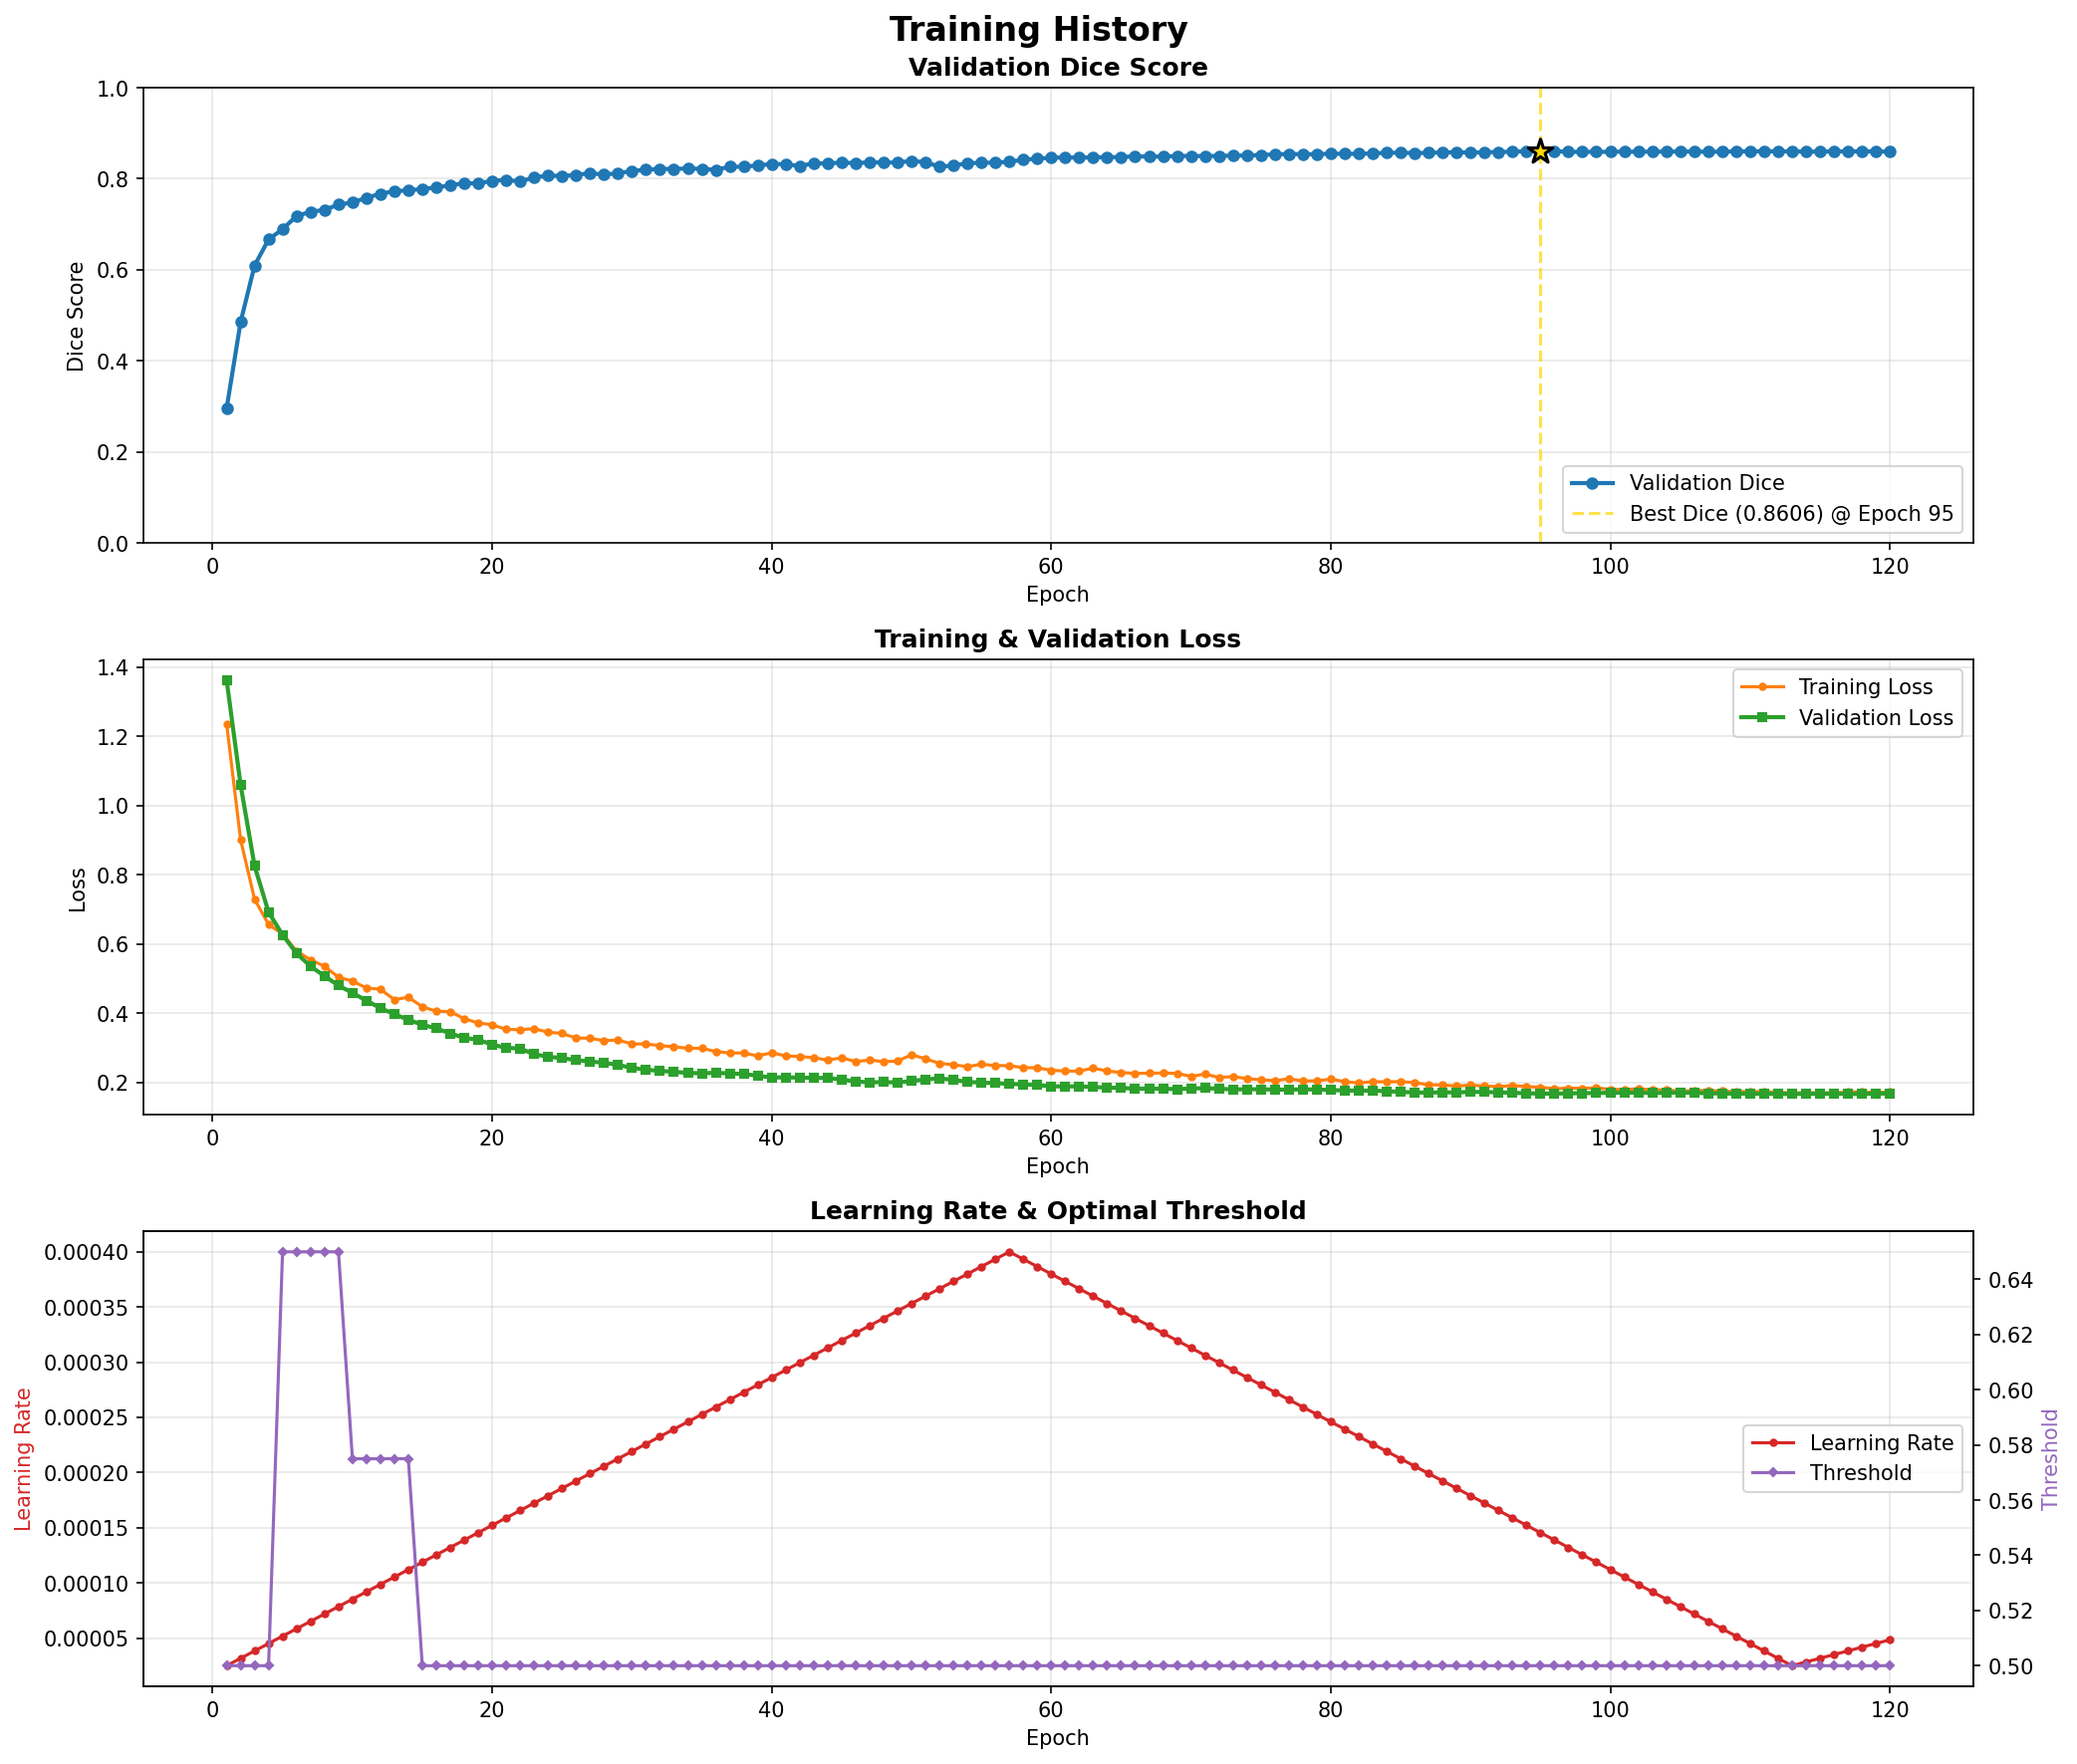

Validation:   0%|          | 0/28 [00:00<?, ?it/s]

Final Dice: 0.8606 | Final IoU: 0.7566


In [9]:
# training history
history = {
    "epoch": [], "train_loss": [], "val_loss": [], "val_loss_dice": [],
    "val_loss_ce": [], "dice": [], "iou": [], "lr": [], "thr": [], "validated": []
}

print("Starting Training...")

best_metric = -1.0
best_epoch = -1
epochs_no_improve = 0
current_thr = CONFIG["init_threshold"]


# get the analogy based on the epoch
def get_curriculum(epoch):
    for stage in reversed(CONFIG["curriculum_stages"]):
        if epoch >= stage["epoch_start"]:
            return stage
    return CONFIG["curriculum_stages"][0]


# loop
for epoch in range(CONFIG["epochs"]):
    # Curriculum update
    curr_stage = get_curriculum(epoch)
    if epoch == curr_stage["epoch_start"]:
        train_dataset.transform = rand_transform(curr_stage["pos"], curr_stage["neg"])
        print(f"\n[Curriculum] Epoch {epoch+1}: {curr_stage['desc']} (pos={curr_stage['pos']}, neg={curr_stage['neg']})")

    # Training
    model.train()
    train_loss_sum = 0.0
    train_batches = 0

    # Memory monitoring
    if epoch == 0:
        print(f"[Memory] Before training: {torch.cuda.memory_allocated()/1e9:.2f} GB allocated")

    pbar_train = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=False)
    optimizer.zero_grad(set_to_none=True)

    for batch_idx, batch in enumerate(pbar_train, 1):
        x = batch["image"].to(device, non_blocking=True).float()
        y = batch["label"].to(device, non_blocking=True).float()

        try:
            x = x.to(memory_format=torch.channels_last_3d)
            y = y.to(memory_format=torch.channels_last_3d)
        except Exception:
            pass

        # Skip bad batches
        if not (torch.isfinite(x).all() and torch.isfinite(y).all()):
            print(f"[Warning] Skipping batch {batch_idx} - non-finite values")
            continue

        # Forward pass
        with torch.cuda.amp.autocast(enabled=True):
            logits = model(x)
            loss = criterion(logits, y)

        if not torch.isfinite(loss):
            print(f"[Warning] Skipping batch {batch_idx} - NaN/Inf loss")
            continue

        # Backward with accumulation
        loss_scaled = loss / CONFIG["accum_steps"]
        scaler.scale(loss_scaled).backward()

        if batch_idx % CONFIG["accum_steps"] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, error_if_nonfinite=False)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            ema.update(model)

        train_loss_sum += float(loss.detach())
        train_batches += 1

        pbar_train.set_postfix({"loss": f"{float(loss):.4f}"})

    # Handle remaining gradients
    if (batch_idx % CONFIG["accum_steps"]) != 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, error_if_nonfinite=False)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
        ema.update(model)

    avg_train_loss = train_loss_sum / max(train_batches, 1)

    # Validation
    do_validate = (epoch + 1) % CONFIG["val_every"] == 0
    val_metrics = None

    if do_validate:
        # Use EMA model for validation
        ema.apply(model)

        # Determine if we should sweep thresholds
        do_sweep = (epoch + 1) % CONFIG["thr_sweep_every"] == 0
        # Calculate component losses in final epochs
        calc_components = epoch > CONFIG["epochs"] - 20

        try:
            val_metrics = validate_model(
                model, val_loader,
                threshold=current_thr,
                do_threshold_sweep=do_sweep,
                calc_components=calc_components
            )
        except torch.cuda.OutOfMemoryError:
            print(f"[OOM] Validation failed at epoch {epoch+1}, skipping...")
            torch.cuda.empty_cache()
            val_metrics = (float('nan'), float('nan'), float('nan'), 0.0, 0.0, None, None)

        ema.restore(model)

        # Unpack metrics
        vloss, vloss_dice, vloss_ce, vdice, viou, best_thr, best_dice_sweep = val_metrics

        # Update threshold if sweep found a better one
        threshold_changed = ""
        if best_thr is not None and best_dice_sweep is not None and (best_dice_sweep - vdice) > 1e-3:
            old_thr = current_thr
            current_thr = best_thr
            threshold_changed = f" | thr {old_thr:.3f}→{current_thr:.3f}"

        # Check for improvement
        is_best = vdice > best_metric + CONFIG["min_delta"]
        if is_best:
            best_metric = vdice
            best_epoch = epoch + 1
            ema.apply(model)
            torch.save(model.state_dict(), CONFIG["best_model_path"])
            ema.restore(model)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Print summary
        print(f"[Epoch {epoch+1:03d}] "
              f"TrainLoss: {avg_train_loss:.4f} | "
              f"ValLoss: {vloss:.4f} | "
              f"ValDice@thr{current_thr:.2f}: {vdice:.4f} | "
              f"ValIoU: {viou:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}{threshold_changed} "
              f"{'| **NEW BEST**' if is_best else ''}")

        if calc_components and not np.isnan(vloss_dice):
            print(f"          └─ Loss Components - Dice: {vloss_dice:.4f}, CE: {vloss_ce:.4f}")

        # Record history
        history["epoch"].append(epoch + 1)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(vloss)
        history["val_loss_dice"].append(vloss_dice)
        history["val_loss_ce"].append(vloss_ce)
        history["dice"].append(vdice)
        history["iou"].append(viou)
        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["thr"].append(current_thr)
        history["validated"].append(True)

    else:
        print(f"[Epoch {epoch+1:03d}] TrainLoss: {avg_train_loss:.4f} | Validation: Skipped")

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(float('nan'))
        history["val_loss_dice"].append(float('nan'))
        history["val_loss_ce"].append(float('nan'))
        history["dice"].append(float('nan'))
        history["iou"].append(float('nan'))
        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["thr"].append(current_thr)
        history["validated"].append(False)

    # Step scheduler
    scheduler.step()

    # Early stopping
    if epochs_no_improve >= CONFIG["patience"]:
        print(f"\n[Early Stopping] No improvement for {CONFIG['patience']} epochs. Best Dice: {best_metric:.4f} @ epoch {best_epoch}")
        break

    # Memory cleanup
    if (epoch + 1) % 10 == 0:
        torch.cuda.empty_cache()

print("")
print(f"Training Complete!")
print(f"Best Validation Dice: {best_metric:.4f} @ Epoch {best_epoch}")
print(f"Best Model Saved: {CONFIG['best_model_path']}")
print(f"Final Threshold: {current_thr:.3f}")
print("")

# plots
print("Generating plots...")

epochs = history["epoch"]
val_epochs = [e for e, v in zip(epochs, history["validated"]) if v]

fig, axes = plt.subplots(3, 1, figsize=(14, 12), dpi=150)
fig.suptitle('Training History', fontsize=16, fontweight='bold')

# dice
ax = axes[0]
ax.plot(val_epochs, [history["dice"][i-1] for i in val_epochs], 'o-',
        color='#1f77b4', linewidth=2, markersize=5, label='Validation Dice')
if best_epoch != -1:
    ax.axvline(x=best_epoch, color='gold', linestyle='--', alpha=0.7,
               label=f'Best Dice ({best_metric:.4f}) @ Epoch {best_epoch}')
    ax.scatter(best_epoch, best_metric, s=150, c='gold', marker='*',
               edgecolors='black', linewidth=1.5, zorder=5)
ax.set_title('Validation Dice Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice Score')
ax.grid(True, alpha=0.3)
ax.legend(loc='lower right')
ax.set_ylim(0, 1)

# losses
ax = axes[1]
ax.plot(epochs, history["train_loss"], 'o-', color='#ff7f0e',
        linewidth=1.5, markersize=3, label='Training Loss')
ax.plot(val_epochs, [history["val_loss"][i-1] for i in val_epochs], 's-',
        color='#2ca02c', linewidth=2, markersize=4, label='Validation Loss')
ax.set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3)
ax.legend()

# other plots (learnign rate and threshold)
ax = axes[2]
ax_twin = ax.twinx()
line1 = ax.plot(epochs, history["lr"], 'o-', color='#d62728',
                linewidth=1.5, markersize=3, label='Learning Rate')
line2 = ax_twin.plot(val_epochs, [history["thr"][i-1] for i in val_epochs], 'D-',
                     color='#9467bd', linewidth=1.5, markersize=3, label='Threshold')
ax.set_title('Learning Rate & Optimal Threshold', fontsize=12, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Learning Rate', color='#d62728')
ax_twin.set_ylabel('Threshold', color='#9467bd')
ax.grid(True, alpha=0.3)
lines = line1 + line2
labs = [l.get_label() for l in lines]
ax.legend(lines, labs, loc='center right')

plt.tight_layout()
plt.savefig("training_history.png", dpi=300, bbox_inches='tight')
print("Plot saved: training_history.png")
plt.show()

model.load_state_dict(torch.load(CONFIG["best_model_path"]))
final_metrics = validate_model(model, val_loader, threshold=current_thr, do_threshold_sweep=True, calc_components=True)
print(f"Final Dice: {final_metrics[3]:.4f} | Final IoU: {final_metrics[4]:.4f}")